In [1]:
import csv
import pandas as pd
import numpy as np
import math
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from wordcloud import WordCloud

import geopandas as gpd
from descartes import PolygonPatch

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sn

Reading datasets
========
* warszawa_desc.csv: description of flats
* warszawa.txt: Information about flats. They will be used to define labels. 
* polish_stopwords.txt: Polish stopwords
* odm.txt: polish dictionary 

In [2]:
with open("data/warszawa_desc.csv") as f:
    reader = csv.reader(f, delimiter=';', quotechar='|')
    lst = []
    col_names = []
    for i,row in enumerate(reader):
        if i == 0:
            col_names = row
            continue
        lst.append(dict(zip(col_names,row)))
sample = pd.DataFrame(lst).set_index('Id')

print('Example descripition:\n\n',sample['Desc']['55582168'])

Example descripition:

  jasne i przestronne mieszkanie czeka na nowego właściciela. do dyspozycji 2 pokoje, oddzielna, widna kuchnia, łazienka, przedpokój, przestronny balkon, piwnica (10m2). nieruchomość w stanie deweloperskim. przygotowana dla nowych właścicieli i stwarzająca im możliwościowi własnej aranżacji wnętrza. mieszkanie znajduje się na 1 piętrze 3 piętrowego bloku z cegły z 1949 r. idealne jako inwestycja lub mieszkanie dla rodziny. 


In [3]:
with open("data/warszawa.csv") as f:
    reader = csv.reader(f, delimiter=';', quotechar='|')
    lst = []
    col_names = []
    for i,row in enumerate(reader):
        if i == 0:
            col_names = row
            continue
        lst.append(dict(zip(col_names,row)))
labels = pd.DataFrame(lst).set_index('Id')[['Borough','age_mean','price_per_sqm',
                                            'building_material','building_type']]
print('Example:\n\n',labels.loc[['55582168']])

Example:

           Borough age_mean price_per_sqm building_material building_type
Id                                                                      
55582168  mokotów     70.0        8750.0             brick         block


In [4]:
with open('utils/odm.txt',encoding='utf-8') as f:
    read = csv.reader(f, delimiter=',', quotechar='|')
    pl_dict = dict()
    for i,row in enumerate(read):
        if len(row) == 1:
            continue
        values = [row[0].lower()] * len(row)
        temp_dict = dict(zip([w.lstrip().lower() for w in row],values))
        pl_dict.update(temp_dict)

print('Example\nWord dane (data in english) in different declension forms is casted to one nominative form')
print('\t',pl_dict['dane'], pl_dict['danych'], pl_dict['daną'])

Example
Word dane (data in english) in different declension forms is casted to one nominative form
	 dany dany dany


In [5]:
with open('utils/polish_stopwords.txt') as f:
    read = csv.reader(f, delimiter=';', quotechar='|')
    stop_words = []
    for i,row in enumerate(read):
        stop_words.append(row[0])
        
print('Example stop words:\n',stop_words[0:200:20])

Example stop words:
 ['a', 'będę', 'cała', 'dobrze', 'gdzies', 'jakichś', 'jemu', 'ktorego', 'ma', 'mozna']


Other datasets
=======
* borough_names: names of borough (with declension forms), They will be removed from flats' description as they might influence our analysis

In [6]:
boroughs_name = ['bemowo','bemowa','bemowu','bemowem','bemowie',
                 'białołęka','białołęki','białołęce','białołękę','białołęką','białołęko',
                 'bielany','bielan','bielanom','bielany','bielanami','bielanach',
                 'mokotów','mokotowa','mokotowowi','mokotowem','mokotowie',
                 'ochota','ochoty','ochotę','ochotą','ochocie','ochoto',
                 'praga','pragi','pradze','pragą','pradze','prago',
                 'rembertów','rembertowa','rembertowowi','rembertów','rembertowem','rembertowie','rembertowie',
                 'śródmieście','śródmieścia','śródmieściu','śródmieściem',
                 'targówek','targówka','targówkowi','targówkiem','targówku',
                 'ursus','ursusa','ursusowi','ursusa','ursusem','ursusie',
                 'ursynów','ursynowa','ursynowowi','ursynów','ursynowem','ursynowie',
                 'wawer','wawra','wawrowi','wawrem','wawrze',
                 'wesoła','wesołą','wesołej',
                 'wilanów','wilanowa','wilanowowi','wilanowem','wilanowie',
                 'włochy','włochów','włochom','włochami','włochach',
                 'wola', 'woli', 'woli', 'wolę', 'wolą', 'woli', 'wolo',
                 'żoliborz','żoliborza','żoliborzowi','żoliborz','żoliborzem','żoliborzu']

Cleaning descriptions
===========
Description are changed in following steps:
* replacing chars: numbers and punctuation symbols with single whitespace character
* replacing double whitespace character with single whitespace characters
* removing stopwords
* removing single character word
* removing borough names
* changing declined words to their basic form

In [7]:
txt = []
for desc in sample['Desc']:
    desc = re.sub('[0123456789,.()$%:*;|!?-_]', ' ', desc)
    desc.replace('  ',' ')
    lst = [w for w in desc.split() if w not in stop_words]
    lst = [w for w in lst if len(w) > 1]
    lst = [w for w in lst if w not in boroughs_name]
    final_lst = []
    for w in lst:
        if w in pl_dict:
            final_lst.append(pl_dict[w])
        else:
            final_lst.append(w)
    txt.append(' '.join(final_lst))    
sample['txt'] = txt 

del pl_dict, stop_words
del lst, final_lst, txt

print('Original descripition:\n\n',sample['Desc']['55582168'],'\n\n')
print('Modified descripition:\n\n',sample['txt']['55582168'])

Original descripition:

  jasne i przestronne mieszkanie czeka na nowego właściciela. do dyspozycji 2 pokoje, oddzielna, widna kuchnia, łazienka, przedpokój, przestronny balkon, piwnica (10m2). nieruchomość w stanie deweloperskim. przygotowana dla nowych właścicieli i stwarzająca im możliwościowi własnej aranżacji wnętrza. mieszkanie znajduje się na 1 piętrze 3 piętrowego bloku z cegły z 1949 r. idealne jako inwestycja lub mieszkanie dla rodziny.  


Modified descripition:

 jasny przestronny mieszkanie czeka nowy właściciel dyspozycja pokój oddzielny widny kuchnia łazienka przedpokój przestronny balkon piwnica nieruchomość stan deweloperski przygotowany nowy właściciel stwarzać możliwościowy własny aranżacja wnętrze mieszkanie znajdywać piętro piętrowy blok cegła idealny inwestycja mieszkanie rodzina


Creating labels
========

We create few labels marking:
* age
* price
* building type and material



**Age_cat**

* 2000-: 2000s
* 1990-1999: 90s
* 1980-1989: 80s
* 1960-1979: communist
* 1945-1959: afterwar
* ... -1944: beforewar

In [8]:
def age_cat_create(x):
    if float(x) <= 18.0:
        return '2000s'
    elif float(x) <= 28.0:
        return '90s'
    elif float(x) <= 38.0:
        return '80s'
    elif float(x) <= 58.0:
        return 'communist'
    elif float(x) <= 73.0:
        return 'afterwar'
    return 'beforewar'
labels['age_cat'] = labels['age_mean'].apply(age_cat_create)

**Price_cat1**

* 1st quintile calculated for whole sample, labelled: *low*
* 2nd quintile calculated for whole sample, labelled: *midlow*
* 3rd quintile calculated for whole sample, labelled: *mid*
* 4th quintile calculated for whole sample, labelled: *midhigh*
* 5th quintile calculated for whole sample, labelled: *high*

In [9]:
labels['price_per_sqm'] = labels['price_per_sqm'].apply(pd.to_numeric)
def price_cat1_create(q20,q40,q60,q80):
    def f(x):
        if x < q20:
            return 'low'
        elif x < q40:
            return 'midlow'
        elif x < q60:
            return 'mid'
        elif x < q80:
            return 'midhigh'
        else:
            return 'high'  
    return f     
labelling_price_cat1 = price_cat1_create(labels['price_per_sqm'].quantile(q=0.2),
                                         labels['price_per_sqm'].quantile(q=0.4),
                                         labels['price_per_sqm'].quantile(q=0.6),
                                         labels['price_per_sqm'].quantile(q=0.8),) 
labels['price_cat1'] = labels['price_per_sqm'].apply(labelling_price_cat1)  

**Price_cat2**

* 1st quintile calculated for each borough, labelled: *low*
* 2nd quintile calculated for each borough, labelled: *midlow*
* 3rd quintile calculated for each borough, labelled: *mid*
* 4th quintile calculated for each borough, labelled: *midhigh*
* 5th quintile calculated for each borough, labelled: *high*

In [10]:
q20_for_borough = dict()
q40_for_borough = dict()
q60_for_borough = dict()
q80_for_borough = dict()

for item in labels['Borough'].unique():
    q20_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.2)
    q40_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.4)
    q60_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.6)
    q80_for_borough[item] = labels[labels['Borough']==item]['price_per_sqm'].quantile(q=0.8)

def price_cat1_create(q20,q40,q60,q80):
    def f(x):
        if x['price_per_sqm'] < q20[x['Borough']]:
            return 'low'
        elif x['price_per_sqm'] < q40[x['Borough']]:
            return 'midlow'
        elif x['price_per_sqm'] < q60[x['Borough']]:
            return 'mid'
        elif x['price_per_sqm'] < q80[x['Borough']]:
            return 'midhigh'
        else:
            return 'high'  
    return f 
labelling_price_cat2 = price_cat1_create(q20_for_borough,q40_for_borough,q60_for_borough,q80_for_borough) 
labels['price_cat2'] = labels.apply(labelling_price_cat2,axis=1) 

**Merging description sample and labels**

In [11]:
sample = pd.merge(sample, labels, right_index=True, left_index=True)

Word clouds
=====================


We present the most frequent words for selected categories in form of word clouds 

First we plot contours of districts that will be used as masks for word clouds

In [12]:
districts = gpd.read_file('utils/waw_suburbs.geojson')
districts['title'] = districts['title'].apply(lambda x: x.lower())
districts = districts.set_index('title')
poly = districts['geometry']

for name, polygon in poly.iteritems():  
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.add_patch(PolygonPatch(polygon, ec='k', alpha=0.5, zorder=2))    
    ax.axis('scaled')
    plt.savefig('utils/'+name+'.png',format='png',bbox_inches='tight')
    plt.close()

**Plotting word cloud for each borough**


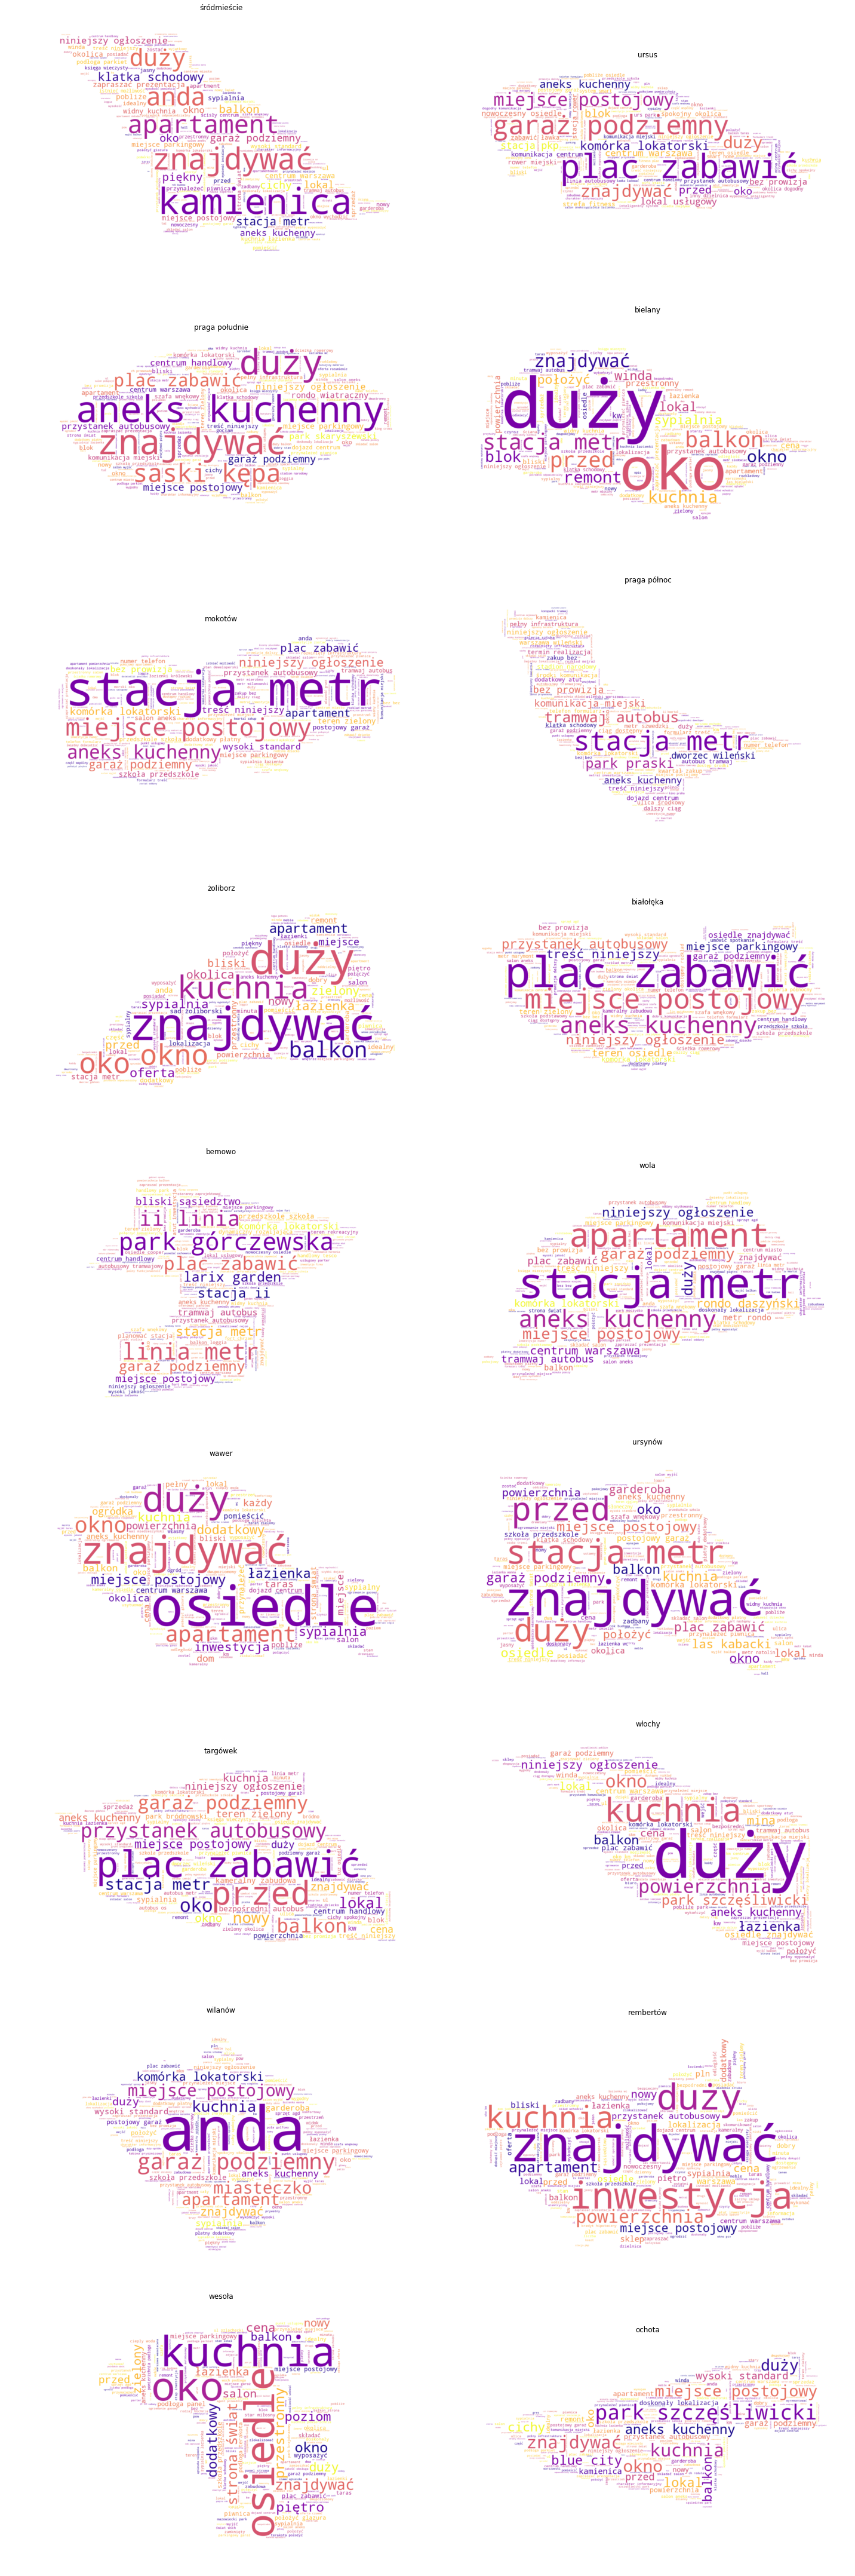

In [13]:
fig, axes = plt.subplots(nrows=9,ncols=2,figsize=(20,60))
r = 0
c = 0

for borough in sample['Borough'].unique():
    text = sample[sample['Borough']==borough]['txt'].str.cat(sep=' ')
    mask = np.array(Image.open('utils/' + borough + '.png'))
    for item in ['pokazać numer','kodeks cywilny','zapraszać kontakt','handlowy rozumienie','podatek pcc','rozumienie kodeks','stan oferta']:
        text = text.replace(item,'')
    for item in ['mieszkanie','budynek','pokój','nieruchomość']:
        text = text.replace(item,'')
    wordcloud = WordCloud(max_font_size=200,background_color='white',mask=mask,colormap=plt.get_cmap('plasma')).generate(text)

    axes[r][c].imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
    axes[r][c].axis("off")
    axes[r][c].set_title(borough)
    axes[r][c].axis('scaled')
    if c:
        c = 0
        r = r + 1
    else:
        c = 1
plt.tight_layout()
plt.show()

**Plotting word cloud for each age category**

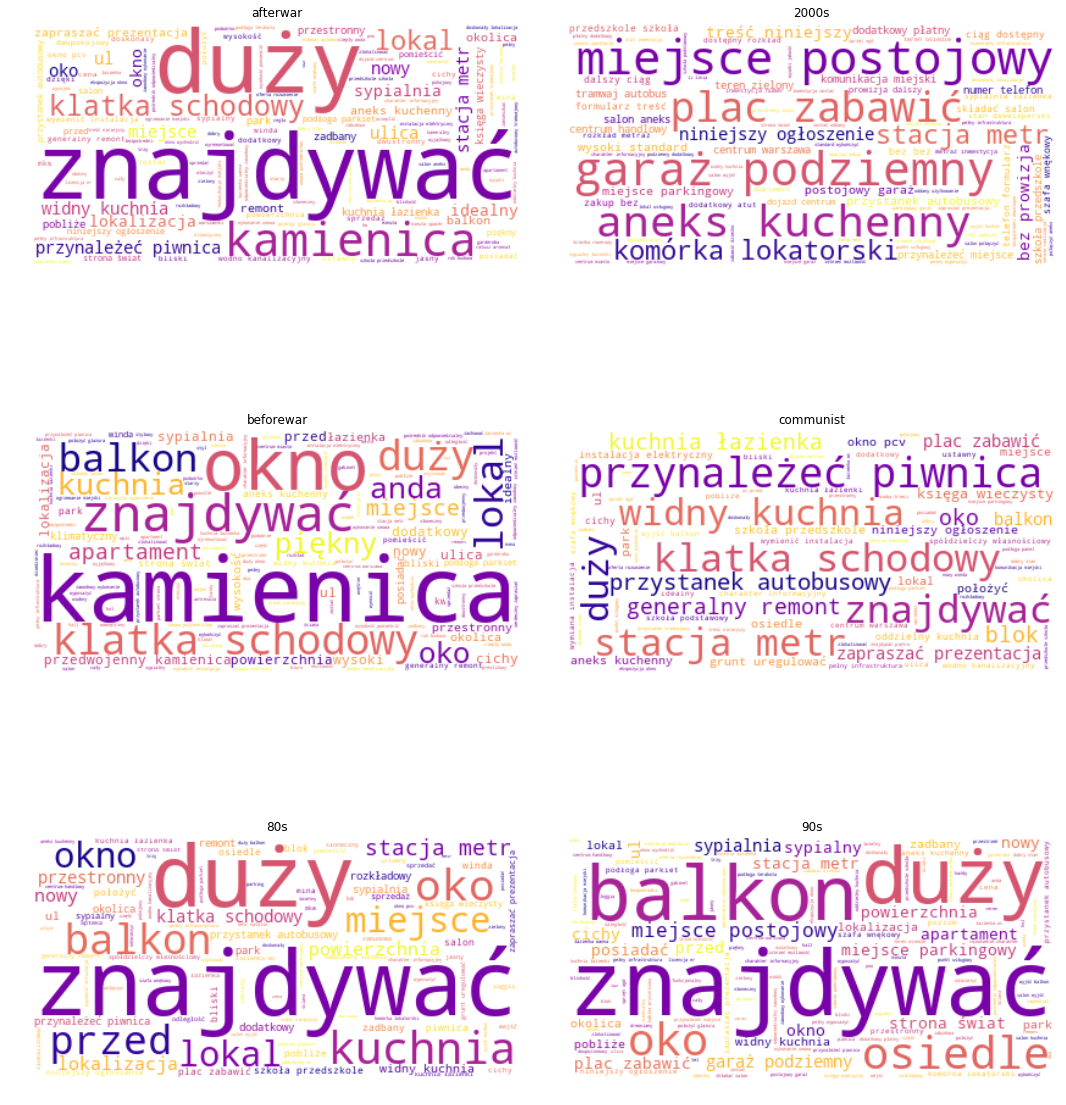

In [14]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,18))
r = 0
c = 0

for age in sample['age_cat'].unique():
    text = sample[sample['age_cat']==age]['txt'].str.cat(sep=' ')
    for item in ['pokazać numer','kodeks cywilny','zapraszać kontakt','handlowy rozumienie','podatek pcc','rozumienie kodeks','stan oferta']:
        text = text.replace(item,'')
    for item in ['mieszkanie','budynek','pokój','nieruchomość']:
        text = text.replace(item,'')
    wordcloud = WordCloud(max_font_size=200,background_color='white',colormap=plt.get_cmap('plasma')).generate(text)

    axes[r][c].imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
    axes[r][c].axis("off")
    axes[r][c].set_title(age)
    axes[r][c].axis('scaled')
    if c:
        c = 0
        r = r + 1
    else:
        c = 1
plt.tight_layout()
plt.show()

**Plotting word cloud for each price category**

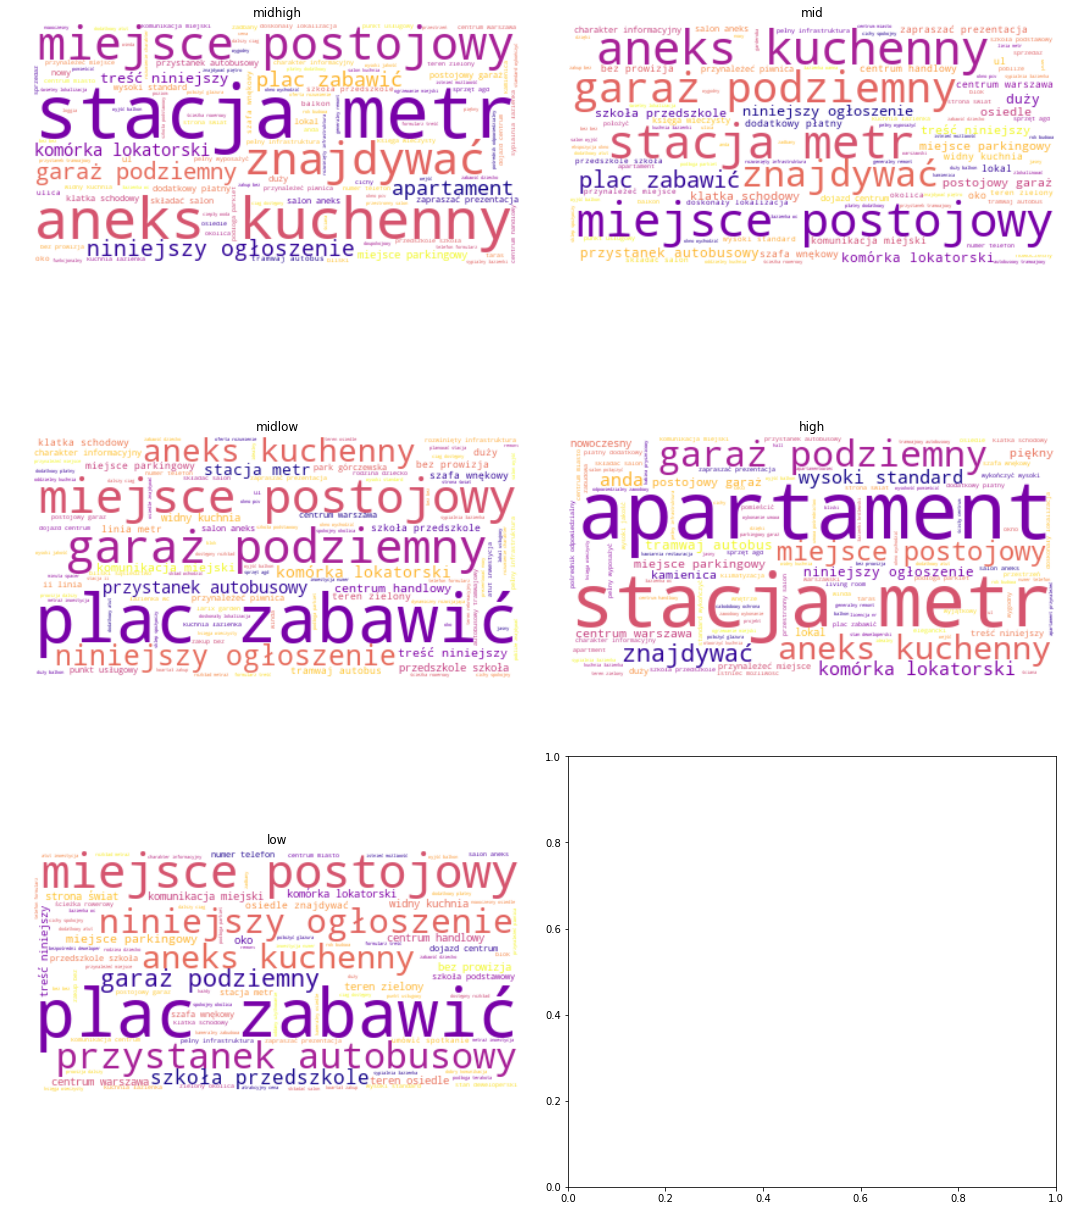

In [15]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,18))
r = 0
c = 0

for price in sample['price_cat1'].unique():
    text = sample[sample['price_cat1']==price]['txt'].str.cat(sep=' ')
    for item in ['pokazać numer','kodeks cywilny','zapraszać kontakt','handlowy rozumienie','podatek pcc','rozumienie kodeks','stan oferta']:
        text = text.replace(item,'')
    for item in ['mieszkanie','budynek','pokój','nieruchomość']:
        text = text.replace(item,'')
    wordcloud = WordCloud(max_font_size=200,background_color='white',colormap=plt.get_cmap('plasma')).generate(text)

    axes[r][c].imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
    axes[r][c].axis("off")
    axes[r][c].set_title(price)
    axes[r][c].axis('scaled')
    if c:
        c = 0
        r = r + 1
    else:
        c = 1
plt.tight_layout()
plt.show()

Term frequency–inverse document frequency
=====================

We perform analysis of flats' description using *Bag of words* model. We create the vector of words contained by descriptions and transform them using TFIDF technique.

Settings
* sublinear_df is set to True to use a logarithmic form for frequency.
* min_df is the minimum numbers of documents a word must be present in to be kept. We will set this parameter to 4 and 10 to check the sensitivity of our analysis to that parameter
* norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

In [16]:
tfidf4 = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='utf-8',ngram_range=(1,2))
features_4df = tfidf4.fit_transform(sample['txt']).toarray()
print('Bag of words for df = 4 counts ',features_4df.shape[1],' observations (uni and bigrams)')

tfidf10 = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='utf-8',ngram_range=(1,2))
features_10df = tfidf10.fit_transform(sample['txt']).toarray()
print('Bag of words for df = 10 counts ',features_10df.shape[1],' observations (uni and bigrams)')

Bag of words for df = 4 counts  48381  observations (uni and bigrams)
Bag of words for df = 10 counts  21497  observations (uni and bigrams)


In [17]:
def perform_text_analysis(df,n,label,tfidf,features):
    cols = list(range(1,n+1))
    test = df[['txt',label]].copy()
    test['category'] = test[label].factorize()[0]
    category_to_id  = test[[label, 'category']].drop_duplicates().sort_values('category').set_index(label).to_dict()['category']

    results = pd.DataFrame()
    for item, category_id in sorted(category_to_id.items()):
        features_chi2 = chi2(features, test.category == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams  = [v for v in feature_names if len(v.split(' ')) == 2]
        trigrams = [v for v in feature_names if len(v.split(' ')) == 3]

        if len(unigrams) > 0:
            dct = dict(zip(cols,unigrams[-n:]))
            dct['Category'] = item + ' (uni)'
            results = results.append(dct,ignore_index=True)
        
        if len(bigrams) > 0:            
            dct = dict(zip(cols,bigrams[-n:]))
            dct['Category'] = item +  ' (bi)'
            results = results.append(dct,ignore_index=True)
        
        if len(trigrams) > 0:            
            dct = dict(zip(cols,unigrams[-n:]))
            dct['Category'] = item + ' (tri)'
            results = results.append(dct,ignore_index=True)
    del test
    results.set_index('Category',inplace=True)
    return results

**Analysis of age**

We analyze what words are used to describe apartments that differ by age. We also check if using different threshold for uni- and bigrams frequency has large impact on results of analysis.

In descipription of old flats (builded before WW2) it is emphesised that flat is located in *before war tenement house*. Also among most frequent term we can find:
* *keep original*,
* *vintage*,
* *original parquet*,
* *original woodwork*,
* *restored tenement house*,
* *masonry (stove)*

In modern flats (2000- ) we can find: *underground garage*, *the basement is included*, *total makeover* and *kitchen with window*.


We can clearly see that Warsaw's boroughs were build in different periods as we see words related to location of flat:
* before and just after the war: Ogród Krasińskich
* 60's and 70's Żoliborz and Praga
* 80's and 90's : Natolin and Ursynów


In [18]:
age_analysis = perform_text_analysis(sample, 12, 'age_cat',tfidf4,features_4df)
age_analysis.head(50)

1                    2   \
Category                                                       
2000s (uni)                  uregulować                 pion   
2000s (bi)                widny kuchnia         bez prowizja   
80s (uni)                          blok             okulicki   
80s (bi)                     mina rower       natolin minuta   
90s (uni)                     relaksowy         dwupoziomowy   
90s (bi)                    las kabacki     ul bohaterewicza   
afterwar (uni)                 podwórko             wymienić   
afterwar (bi)       przynależeć piwnica  piętrowej kamienica   
beforewar (uni)               służbówka           ujazdowski   
beforewar (bi)             piec kaflowy  oryginalny stolarka   
communist (uni)                     sad                 pion   
communist (bi)   instalacja elektryczny             park sad   

                                        3                       4   \
Category                                                             
2000s (uni)                         wymian                     pcc   
2000s (bi)                     bez podatek  instalacja elektryczny   
80s (uni)                           gocław              uregulować   
80s (bi)                        gips gładź            blok powstać   
90s (uni)                              lex               książkowy   
90s (bi)                   marta kosmowski           kosmowski tel   
afterwar (uni)                  instalacja                 piwnica   
afterwar (bi)                   cegła nowy         czynsz własność   
beforewar (uni)                   filtrowy             klimatyczny   
beforewar (bi)     odrestaurować kamienica    mieszkanie kamienica   
communist (uni)                 żoliborski                  wymian   
communist (bi)   spółdzielczo własnościowy      wymiana instalacja   

                                        5                     6   \
Category                                                           
2000s (uni)                         klatka             generalny   
2000s (bi)       spółdzielczy własnościowy       garaż podziemny   
80s (uni)                         ocieplić                karton   
80s (bi)                    gładź wymienić         mieścić rower   
90s (uni)                           poziom               zalecać   
90s (bi)                        metr kabat            kabat mina   
afterwar (uni)               pięćdziesiąty                remont   
afterwar (bi)                 pokój zrobić        kamienica tych   
beforewar (uni)                    kaflowy              podwórze   
beforewar (bi)          oryginalny parkiet  kamienica mieszkanie   
communist (uni)                   ocieplić             generalny   
communist (bi)           możliwość założyć             rondo onz   

                                           7                    8   \
Category                                                             
2000s (uni)                        inwestycja           instalacja   
2000s (bi)                wodno kanalizacyjny          podatek pcc   
80s (uni)                        spółdzielczy                 buda   
80s (bi)         nieruchomościkonrad frejlich         dębowy szary   
90s (uni)                           kosmowski           inwestycja   
90s (bi)                 informacyjny zalecać  zalecać weryfikacja   
afterwar (uni)                           tych              muranów   
afterwar (bi)                 kamienica cegła        budynek cegła   
beforewar (uni)                     zabytkowy             zachować   
beforewar (bi)              budynek kamienica  zachować oryginalny   
communist (uni)                    instalacja           uregulować   
communist (bi)      spółdzielczy własnościowy     grunt uregulować   

                                  9                           10  \
Category                                                           
2000s (uni)                kamienica                    wymienić   
2000s (bi)           

In [19]:
age_analysis = perform_text_analysis(sample, 12, 'age_cat', tfidf10, features_10df)
age_analysis.head(50)

1                      2   \
Category                                                         
2000s (uni)                  uregulować                   pion   
2000s (bi)                 bez prowizja          widny kuchnia   
80s (uni)                       piwnica               stokłosa   
80s (bi)             natolin mieszkanie  doskonały rozplanować   
90s (uni)                           pcc            weryfikacja   
90s (bi)                pierwszy poziom           dolny poziom   
afterwar (uni)                 podwórko               wymienić   
afterwar (bi)       przynależeć piwnica    piętrowej kamienica   
beforewar (uni)               służbówka                   sejm   
beforewar (bi)         kamienica remont    oryginalny stolarka   
communist (uni)            spółdzielczy                   pion   
communist (bi)   instalacja elektryczny               park sad   

                                   3                          4   \
Category                                                           
2000s (uni)                    wymian                        pcc   
2000s (bi)                bez podatek     instalacja elektryczny   
80s (uni)                        gips                     gocław   
80s (bi)               okno kaloryfer      plastikowy ekspozycja   
90s (uni)                     piwnica                  kamienica   
90s (bi)               sprzedaż pokój               poziom salon   
afterwar (uni)             instalacja                    piwnica   
afterwar (bi)         metr racławicki               metro ratusz   
beforewar (uni)            ujazdowski                    kaflowy   
beforewar (bi)   mieszkanie kamienica    odrestaurować kamienica   
communist (uni)                wymian                 żoliborski   
communist (bi)     wymiana instalacja  spółdzielczo własnościowy   

                                        5                     6   \
Category                                                           
2000s (uni)                         klatka             generalny   
2000s (bi)       spółdzielczy własnościowy   wodno kanalizacyjny   
80s (uni)                             blok            uregulować   
80s (bi)                        duży winda             wola park   
90s (uni)                        niniejsza                 schód   
90s (bi)                       las kabacki            metr kabat   
afterwar (uni)               pięćdziesiąty                remont   
afterwar (bi)              czynsz własność        kamienica tych   
beforewar (uni)                klimatyczny              podwórze   
beforewar (bi)          oryginalny parkiet  kamienica mieszkanie   
communist (uni)                   ocieplić             generalny   
communist (bi)           możliwość założyć             rondo onz   

                                        7                          8   \
Category                                                                
2000s (uni)                     inwestycja                 instalacja   
2000s (bi)                 garaż podziemny                podatek pcc   
80s (uni)                         ocieplić                     karton   
80s (bi)                   ocieplić klatka  spółdzielczy własnościowy   
90s (uni)                     dwupoziomowy                    zalecać   
90s (bi)              informacyjny zalecać        zalecać weryfikacja   
afterwar (uni)                        tych                    muranów   
afterwar (bi)              kamienica cegła              budynek cegła   
beforewar (uni)                  zabytkowy                   zachować   
beforewar (bi)           budynek kamienica        zachować oryginalny   
communist (uni)                 instalacja                 uregulować   
communist (bi)   spółdzielczy własnościowy           grunt uregulować   

                                  9                             10  \
Category                                                             
2000s (uni)                kamienica       

**Analysis of prizes**

We observe that most expensive flats are described by: *luxuary apartment*, *apartment*. Those apartments are also located near most prestigious streets: Krakowskie Przedmieście, Nowy Świat, Bulwary Wiślane 
Also some descirptions of most expensive flats are written in english.

The cheapest flats (low and midlow) are located in east-north districts (*Ząbki*,*Tarchomin*,*Żerań*), probably far from the city center that is why the good comunication is emphesised (*direct bus*, *SKM train stop*), sport facilites (*active live*, *recreation*). 

If we look at relatively expensive flats (most expensive in given borough), we observe that it is emphasised that flat is *finished to a high standard* and close to *green parks*.

In [20]:
price_cat1 = perform_text_analysis(sample, 12, 'price_cat1',tfidf4,features_4df)
price_cat1.head(60)

1                  2                  3   \
Category                                                                      
high (uni)                   recepcja          apartment      odrestaurować   
high (bi)         zaledwie apartament             in the     nauka kopernik   
low (uni)                       derby              nisko            osiedle   
low (bi)               przystanek skm     posiadać układ      metr marymont   
mid (uni)                    zaludnić                zoo           imieniny   
mid (bi)              szwedzki stacja      środkowy stać      ruch samochód   
midhigh (uni)               karolkowy           cmentarz          krajobraz   
midhigh (bi)   kameralność inwestycja  królikarnia wosir         staw dobry   
midlow (uni)              wytchnienie              sześć                mór   
midlow (bi)             miejski dawać       chrzan teren  kondygnacja lokal   

                                 4                5                       6   \
Category                                                                       
high (uni)                       is               of                    anda   
high (bi)      luksusowy apartament  malowniczy park  apartament przynależeć   
low (uni)                     kanał              urs                   ząbki   
low (bi)           galeria północny   dostępny różny        usługowy okolica   
mid (uni)                 przemiana      zaściankowy                  cienić   
mid (bi)                zmiana cały   rowerowy ulica          wzorzec zmiana   
midhigh (uni)                 łuków    kilkurodzinny              wilanowski   
midhigh (bi)         wosir siłownia          in staw      daleki królikarnia   
midlow (uni)               sznajdra    wszechstronny                  cooper   
midlow (bi)           myśl potrzeby    usługi bliski      estetyczny osiedle   

                               7                     8                     9   \
Category                                                                        
high (uni)              luksusowy            prestiżowy                   the   
high (bi)           centrum nauka        bulwar wiślany  apartament wykończyć   
low (uni)              marywilska          płochocińska                 żerań   
low (bi)       kameralny zabudowa        metro marymont    marywilska osiedle   
mid (uni)                 mieście       bezpieczniejszy               wzorzec   
mid (bi)             ruch lokalny         środkowy ruch            czas ulica   
midhigh (uni)           bartoszek            bukowiński            wałbrzyska   
midhigh (bi)        apteka daleki  dwupiętrowy zabudowa     chronić krajobraz   
midlow (uni)            glinianka              corpores            górczewska   
midlow (bi)      pomiędzy aktywny      miasto dzielnica       pokojowe metraż   

                                10                      11                 12  
Category                                                                       
high (uni)                 powiśle               kamienica         apartament  
high (bi)                   of the  krakowski przedmieście         nowy świat  
low (uni)                tarchomin                marymont           żerański  
low (bi)             most północny     bezpośredni autobus     kanał żerański  
mid (uni)        najpotrzebniejszy                szwedzki           środkowy  
mid (bi)       samochód ograniczyć           metr szwedzki     ulica środkowy  
midhigh (uni)                wosir              podbipięta       dominikański  
midhigh (bi)    podbipięta autobus    dominikański autobus  najbliższy stacja  
midlow (uni)                chrzan                  garden              larix  
midlow (bi)         rekreacyjny in         park górczewska       larix garden

In [21]:
price_cat1 = perform_text_analysis(sample, 12, 'price_cat1',tfidf10,features_10df)
price_cat1.head(60)

1                   2               3   \
Category                                                                    
high (uni)                   recepcja           apartment              is   
high (bi)             malowniczy park       the apartment  nauka kopernik   
low (uni)                   zdziarski                 urs           nisko   
low (bi)               zielony dolina  postojowy naziemny       tras most   
mid (uni)                      praski          apartament             zoo   
mid (bi)                ruch samochód         zmiana cały  rowerowy ulica   
midhigh (uni)                obrzeżny               łuków       krajobraz   
midhigh (bi)   kameralność inwestycja      wosir siłownia      staw dobry   
midlow (uni)              wytchnienie               sześć             mór   
midlow (bi)           standard wygoda         aktywny żyć   myśl potrzeby   

                              4                     5                   6   \
Category                                                                     
high (uni)         odrestaurować                    of                anda   
high (bi)                 in the  luksusowy apartament       centrum nauka   
low (uni)             marywilska                 kanał             osiedle   
low (bi)          dostępny różny      galeria północny       metr marymont   
mid (uni)                 cienić               mieście     bezpieczniejszy   
mid (bi)          wzorzec zmiana           park praski        ruch lokalny   
midhigh (uni)          karolkowy         kilkurodzinny           bartoszek   
midhigh (bi)             in staw     królikarnia wosir  daleki królikarnia   
midlow (uni)            sznajdra         wszechstronny              cooper   
midlow (bi)    kondygnacja lokal         usługi bliski  estetyczny osiedle   

                                   7                   8   \
Category                                                    
high (uni)                  luksusowy          prestiżowy   
high (bi)      apartament przynależeć      bulwar wiślany   
low (uni)                płochocińska               ząbki   
low (bi)           kameralny zabudowa  marywilska osiedle   
mid (uni)                     wzorzec            szwedzka   
mid (bi)        przedszkole odległość       środkowy ruch   
midhigh (uni)              wilanowski          wałbrzyska   
midhigh (bi)     dwupiętrowy zabudowa       apteka daleki   
midlow (uni)                 corpores           glinianka   
midlow (bi)          pomiędzy aktywny    miasto dzielnica   

                                 9                       10  \
Category                                                      
high (uni)                  powiśle                     the   
high (bi)      apartament wykończyć  krakowski przedmieście   
low (uni)                     żerań               tarchomin   
low (bi)             metro marymont     bezpośredni autobus   
mid (uni)               zaściankowy       najpotrzebniejszy   
mid (bi)                 czas ulica     samochód ograniczyć   
midhigh (uni)            bukowiński                   wosir   
midhigh (bi)     podbipięta autobus       chronić krajobraz   
midlow (uni)             górczewska                  chrzan   
midlow (bi)          rekreacyjny in         pokojowe metraż   

                                 11                 12  
Category                                                
high (uni)                kamienica         apartament  
high (bi)                    of the         nowy świat  
low (uni)                  marymont           żerański  
low (bi)              most północny     kanał żerański  
mid (uni)                  szwedzki           środkowy  
mid (bi)              metr szwedzki     ulica środkowy  
midhigh (uni)            podbipięta       dominikański  
midhigh (bi)   dominikański autobus  najbliższy stacja  
midlow (uni)                 garden              larix  
midlow (bi)         park górczewska       larix garden

In [22]:
price_cat2 = perform_text_analysis(sample, 12, 'price_cat2',tfidf4,features_4df)
price_cat2.head(60)

1                    2                   3   \
Category                                                                    
high (uni)                radium                  eko              golden   
high (bi)       prywatny zielony    zapewniać idealny    wierzbno tramwaj   
low (uni)                 poznań         rembertowski               ząbki   
low (bi)           zielony każdy         pakiet smart      osiedlowy duży   
mid (uni)                  sześć               cooper            sznajdra   
mid (bi)           projekt larix       firma corpores   rekreacja kontakt   
midhigh (uni)          ostrogski               marina            zbiornik   
midhigh (bi)    luxor residences  parkiet sztukateria  elektryk hydraulik   
midlow (uni)               lerch           dyrekcyjny              hennel   
midlow (bi)    podziemny wygodny        projekt teren     dziecko zwierzę   

                                 4                       5                 6   \
Category                                                                        
high (uni)                     with               apartment              anda   
high (bi)             polski radium                eko park        golden key   
low (uni)                rekreayjno              apartament      wypoczynkowe   
low (bi)                ul sowiński          strefa zielony  skrzatki pokazać   
mid (uni)                       mór                corpores         glinianka   
mid (bi)               in glinianka     dzielnica wyjątkowy  komfort przyszły   
midhigh (uni)           zamieszkały              residences             gęsty   
midhigh (bi)   marvipol development  dwukondygnacyjny garaż        park laski   
midlow (uni)                   jack              kowalewski        przestanek   
midlow (bi)    mieszkanie podziemny        ściana niektórzy  spożywczy bliski   

                               7                    8   \
Category                                                 
high (uni)                     is            penthouse   
high (bi)                  of the     park prezentować   
low (uni)             łopuszański                wsród   
low (bi)            bogaty strefa       spotkanie anna   
mid (uni)              podbipięta         dominikański   
mid (bi)       podbipięta autobus       ostatni stacja   
midhigh (uni)             sprzety               pięcio   
midhigh (bi)      kamienica cichy  początek inwestycja   
midlow (uni)          kształtować                burza   
midlow (bi)          metraż lokal          os lewandów   

                                   9                      10  \
Category                                                       
high (uni)                         of                    the   
high (bi)         zaledwie apartament   luksusowy apartament   
low (uni)                     hadlowo          optymistyczny   
low (bi)                anna skrzatki  przychodzień mniejszy   
mid (uni)               wszechstronny                 chrzan   
mid (bi)         dominikański autobus         rekreacyjny in   
midhigh (uni)                   hygge                  sushi   
midhigh (bi)   panoramiczny drewniany       prysznic budynek   
midlow (uni)                   garażu                  derby   
midlow (bi)             autobus który           zrobić pokój   

                                 11                    12  
Category                                                   
high (uni)                luksusowy            apartament  
high (bi)           malowniczy park  apartament wykończyć  
low (uni)                  bruzdowy              skrzatki  
low (bi)            ekspozycja etap     sowiński warszawa  
mid (uni)                    garden                 larix  
mid (bi)               istotny atut          larix garden  
midhigh (uni)          zakroczymski                 luxor  
midhigh (bi)       balkon dzielnica  handlowy rekreacyjny  
midlow (uni)                    urs            apartament  
midlow

In [23]:
price_cat2 = perform_text_analysis(sample, 12, 'price_cat2',tfidf10,features_10df)
price_cat2.head(60)

1                  2                      3   \
Category                                                                     
high (uni)                   key             golden                    eko   
high (bi)       prywatny zielony  zapewniać idealny       wierzbno tramwaj   
low (uni)           dwupoziomowy       rembertowski             rekreayjno   
low (bi)       elegancki osiedle     mniejszy sklep          zielony każdy   
mid (uni)             różnorodny             cooper               sznajdra   
mid (bi)        położyć zachodni    standard wygoda  państwo wszechstronny   
midhigh (uni)               stok      bobrowieckiej              piekarnik   
midhigh (bi)    pobliże łazienki   recepcja ochrona        zamek ostrogski   
midlow (uni)          przestanek               jack          przeprowadzka   
midlow (bi)          akcja burza        ul sobieski         tenisowy basen   

                               4                    5                     6   \
Category                                                                       
high (uni)                   with            apartment                  anda   
high (bi)           polski radium           golden key              eko park   
low (uni)            wypoczynkowe          łopuszański                 ząbki   
low (bi)             pakiet smart       osiedlowy duży        strefa zielony   
mid (uni)                     mór            glinianka              corpores   
mid (bi)       glinianka sznajdra  dzielnica wyjątkowy    podbipięta autobus   
midhigh (uni)              sprzęt            nieliczni              kamienny   
midhigh (bi)       zbiornik wodny            pln zakup  informacja zapraszać   
midlow (uni)            zdziarski           zawadowski           kształtować   
midlow (bi)           os lewandów       zielony dolina          metraż lokal   

                             7                    8                       9   \
Category                                                                       
high (uni)                   is            penthouse                      of   
high (bi)      park prezentować  zaledwie apartament         malowniczy park   
low (uni)                 wsród           apartament                 hadlowo   
low (bi)          anna skrzatki       spotkanie anna        skrzatki pokazać   
mid (uni)            podbipięta         dominikański           wszechstronny   
mid (bi)       komfort przyszły       rekreacyjny in    dominikański autobus   
midhigh (uni)            marina            ostrogski                zbiornik   
midhigh (bi)   remont wykończyć           park laski  dwukondygnacyjny garaż   
midlow (uni)        zaściankowy                derby                   burza   
midlow (bi)      sam inwestycja        autobus który      deweloper kupujący   

                                10                     11  \
Category                                                    
high (uni)                     the              luksusowy   
high (bi)                   of the   luksusowy apartament   
low (uni)            optymistyczny               bruzdowy   
low (bi)             bogaty strefa  przychodzień mniejszy   
mid (uni)                   chrzan                 garden   
mid (bi)            ostatni stacja           istotny atut   
midhigh (uni)          zamieszkały                  gęsty   
midhigh (bi)   restauracja knajpka          autobus sklep   
midlow (uni)                garażu                    urs   
midlow (bi)          hol usytuować    skomunikować miasto   

                                   12  
Category                               
high (uni)                 apartament  
high (bi)        apartament wykończyć  
low (uni)                    skrzatki  
low (bi)              ekspozycja etap  
mid (uni)                       larix  
mid (bi)                 larix garden  
midhigh (uni)                   sushi  
midhigh (bi)   panoramiczny drewniany  
midlow (uni)               apartament 

**Analysis of boroughs**

In [24]:
boroughs = perform_text_analysis(sample, 12, 'Borough',tfidf4,features_4df)
boroughs.head(60)

1                      2   \
Category                                                               
bemowo (uni)                    wszechstronny                    bem   
bemowo (bi)              funkcjonalność każdy   zaprojektować chcieć   
białołęka (uni)                     zdziarski                  kanał   
białołęka (bi)               usługowy okolica         dostępny różny   
bielany (uni)                          keller                   uksw   
bielany (bi)                    ul marymoncki       metro wawrzyszew   
mokotów (uni)                            best             wilanowski   
mokotów (bi)                    park sielecki      wilanowski stacja   
ochota (uni)                           ochota         włodarzewskiej   
ochota (bi)                    osiedlowy duży                city ch   
praga południe (uni)                  grochów           ostrobramski   
praga południe (bi)                park znicz          handlowy king   
praga północ (uni)                     północ                 środki   
praga północ (bi)               wileński nowy       środkowy tramwaj   
rembertów (uni)                     zalesione                 czynne   
rembertów (bi)              chmieltel pokazać       maciej chmieltel   
targówek (uni)                       czytanie                    tuz   
targówek (bi)                  projekt szybki   miejsce przystosować   
ursus (uni)                        zapowiadać                 władze   
ursus (bi)                    rozwijać zgodny           pkp północny   
ursynów (uni)                      ursynowski               wąwozowy   
ursynów (bi)                    poniższy opis   oględziny informacja   
wawer (uni)                             sadul                    mza   
wawer (bi)               mieszkanie poziomowy           klucz oddany   
wesoła (uni)                        komórkowy               antenowy   
wesoła (bi)                     biedronka amp  pokryć blachodachówka   
wilanów (uni)                           vogel                  pałac   
wilanów (bi)          wyróżniać optymistyczny     elitarny elegancki   
wola (uni)                             książę                 janusz   
wola (bi)                           al prymas             metr płock   
włochy (uni)                    szczęśliwicki              kombatant   
włochy (bi)                 rakowiec warszawa    zaprojektować patio   
śródmieście (uni)                przedmieście              zbawiciel   
śródmieście (bi)                   trzy krzyż    powiśle najbardziej   
żoliborz (uni)                       elbląski            popiełuszko   
żoliborz (bi)                   żoliborski ul       handlowy arkadia   

                                        3                       4   \
Category                                                             
bemowo (uni)                         sześć                corpores   
bemowo (bi)                 potrzeby cenić  powierzchnia zapewniać   
białołęka (uni)               płochocińska                  klasyk   
białołęka (bi)                metr młociny          zielony dolina   
bielany (uni)                   broniewski                 herbert   
bielany (bi)                   staw keller             keller park   
mokotów (uni)                   cybernetyk                    mall   
mokotów (bi)                   park morski  jeziorko czerniakowski   
ochota (uni)                  szczęśliwice             łopuszański   
ochota (bi)                  anna skrzatki        skrzatki pokazać   
praga południe (uni)               szembek                    king   
praga południe (bi)        cross promenada        ulica wiatraczny   
praga północ (uni)           futeraekspert                wileńska   
praga północ (bi)        konopacki tramwaj        znakomity dostęp   
rembertów (uni)              kmzakończenie                sportowa   
rembertów (bi)            przebudowa węzeł         akademia obrona   
targówek (uni)                     zacisze    

In [25]:
boroughs = perform_text_analysis(sample, 12, 'Borough',tfidf10,features_10df)
boroughs.head(60)

1                       2   \
Category                                                             
bemowo (uni)                 wszechstronny                lazurowy   
bemowo (bi)                     rejon fort  powierzchnia zapewniać   
białołęka (uni)                    młociny                   kanał   
białołęka (bi)        nowodwory mieszkanie          dostępny różny   
bielany (uni)                       keller                    uksw   
bielany (bi)              żeromski tramwaj               park kępa   
mokotów (uni)                   wilanowski                    best   
mokotów (bi)                  park arkadia           park sielecki   
ochota (uni)                  szczęśliwice            białobrzeski   
ochota (bi)                 osiedlowy duży          spotkanie anna   
praga południe (uni)               grochów            ostrobramski   
praga południe (bi)       ulica wiatraczny           park poliński   
praga północ (uni)           futeraekspert                szwedzka   
praga północ (bi)        konopacki tramwaj        środkowy tramwaj   
rembertów (uni)                 przystępny               wszystkie   
rembertów (bi)            las rembertowski              węzeł mars   
targówek (uni)           matyjaszczyktreść                czytanie   
targówek (bi)            bliski przestanek  przystosować grillować   
ursus (uni)                     zapowiadać             czechowicki   
ursus (bi)                    pkp północny         kursować minuta   
ursynów (uni)                     wąwozowy              ursynowski   
ursynów (bi)                numer poniższy             sp wąwozowy   
wawer (uni)                            wał             międzylesie   
wawer (bi)                 komora spalanie        zamknięty komora   
wesoła (uni)                      hubertus                wawertel   
wesoła (bi)                 własny ogródka           inwestycja ul   
wilanów (uni)                   rekreayjno                  ostoja   
wilanów (bi)              hadlowo usługowe           poznań oferta   
wola (uni)                            młyn                   rondo   
wola (bi)                        al prymas            pkp kasprzak   
włochy (uni)                         włoch              koziorożec   
włochy (bi)               estetyczny dobry        połączyć funkcja   
śródmieście (uni)             przedmieście               zbawiciel   
śródmieście (bi)       powiśle najbardziej              trzy krzyż   
żoliborz (uni)                     potocki                inwalida   
żoliborz (bi)              dzielnica pełny           metr marymont   

                                             3                    4   \
Category                                                               
bemowo (uni)                           corpores            glinianka   
bemowo (bi)                  zlokalizować rejon      planować stacja   
białołęka (uni)                          klasyk           marywilska   
białołęka (bi)                     ulica klasyk         metr młociny   
bielany (uni)                        broniewski              herbert   
bielany (bi)                   słodowiec stacja          staw keller   
mokotów (uni)                        cybernetyk                 mall   
mokotów (bi)                    metr wilanowski          park morski   
ochota (uni)                     włodarzewskiej          łopuszański   
ochota (bi)                       anna skrzatki        bogaty strefa   
praga południe (uni)                    szembek                 king   
praga południe (bi)               handlowy king      cross promenada   
praga północ (uni)                       północ             wileńska   
praga północ (bi)              dworzec wileński       galeria sztuka   
rembertów (uni)                        akademia             poprawić   
rembertów (bi)        zainteresowany mieszkanie   prezentacja maciej   
targówek (uni)                              tuz             grodzisk   
targówek (b

Analysis of building materials
----------------------

In [26]:
materials = perform_text_analysis(sample, 12, 'building_material',tfidf4,features_4df)
materials.head(60)

1                          2   \
Category                                                                     
aerated_concrete (uni)                    haven                 przyciągać   
aerated_concrete (bi)       mieszkańców pobliże  zainteresowany inwestorów   
breezeblock (uni)                         równy                      walor   
breezeblock (bi)           zaprojektować chcieć             szkoła gabinet   
brick (uni)                             podatek                        pcc   
brick (bi)                    kontakt zapraszać              budynek cegła   
concrete (uni)                            tresa                   whirpool   
concrete (bi)              zainwestować kapitał             pierwotny stan   
concrete_plate (uni)                  generalny                   wymienić   
concrete_plate (bi)                 kino szkoła               numer żaneta   
hydroton (uni)                      zamieszkany                      north   
hydroton (bi)                  lokalizacja cena       doskonały zaopatrzyć   
missing (uni)                        przykładać                   zawodowy   
missing (bi)                 dyspozycja godzina         zawodowy wykonanie   
other (uni)                        czarnomorski                posiadający   
other (bi)                        kwartał zakup                  zakup bez   
reinforced_concrete (uni)                trepte                    ewelina   
reinforced_concrete (bi)          klinik szkoła              uroczy alejka   
silikat (uni)                           zasiegu                     kmmałe   
silikat (bi)                deweloper deweloper      ekologiczny możliwość   
wood (uni)                           komercyjny                      bonus   
wood (bi)                   telefoniczny oferta             odnowić zostać   

                                                    3   \
Category                                                 
aerated_concrete (uni)                           coraz   
aerated_concrete (bi)            doskonałą lokalizacja   
breezeblock (uni)                           dynamiczny   
breezeblock (bi)                  funkcjonalność każdy   
brick (uni)                                    autobus   
brick (bi)                             prowizja dalszy   
concrete (uni)                             najszybciej   
concrete (bi)                         przedostać każdy   
concrete_plate (uni)             nieruchomościlicencja   
concrete_plate (bi)        nieruchomościlicencja numer   
hydroton (uni)                               zniszczyć   
hydroton (bi)                          dzierżawa grunt   
missing (uni)                                  zalecać   
missing (bi)                         oferta rozumienie   
other (uni)                                  warneński   
other (bi)                           metraż inwestycja   
reinforced_concrete (uni)                    replacing   
reinforced_concrete (bi)                który wspierać   
silikat (uni)                               tyskomórki   
silikat (bi)                   bezpośrednim sąsiedztwo   
wood (uni)                                     weranda   
wood (bi)                               północny widok   

                                                     4                   5   \
Category                                                                      
aerated_concrete (uni)                      mieszkańców           balkonami   
aerated_concrete (bi)                    stały rozwijać      koniec galeria   
breezeblock (uni)                           wytchnienie                 mór   
breezeblock (bi)                           sześć cztery      gabinet opieka   
brick (uni)                                   formularz                ciąg   
brick (bi)                                 bez prowizja     formularz treść   
concrete (uni)                                     viii         prezentację   
concrete (bi)                         szybki przedostać     uwaga za

Analysis of building types
----------------------

In [27]:
building_type = perform_text_analysis(sample, 12, 'building_type',tfidf4,features_4df)
building_type.head(60)

1                      2   \
Category                                                       
apartment (uni)            inwestycja                    hol   
apartment (bi)   inwestycja zapraszać      metraż inwestycja   
block (uni)                    chrzan             inwestycja   
block (bi)               larix garden       dostępny rozkład   
house (uni)                  poddasze               dąbrówka   
house (bi)             użytek idealny        zielony fitness   
infill (uni)                 kaufland               kilkaset   
infill (bi)               hałas ulica   położyć nieruchomość   
loft (uni)               nowoczesność                jacuzzi   
loft (bi)            warszawa budynek  prestiżowy inwestycja   
missing (uni)              nowabalkon             salonemtyp   
missing (bi)        godzina zapraszać     państwo dyspozycja   
row_house (uni)               groszek                   czar   
row_house (bi)        międzylesie skm            pomoc biuro   
tenement (uni)                  stary             ujazdowski   
tenement (bi)         kamienica pokój   kamienica mieszkanie   

                                   3                        4   \
Category                                                         
apartment (uni)           prezentować                  piwnica   
apartment (bi)      kontakt zapraszać                  pcc bez   
block (uni)                    garden               prestiżowy   
block (bi)              kwartał zakup        kontakt zapraszać   
house (uni)                   urzędów               rozmieścić   
house (bi)            poziom łazienka             poziom każdy   
infill (uni)                   stawać                  stalowy   
infill (bi)            rok dynamiczny            sprzęt pralka   
loft (uni)                    żelazny                     sala   
loft (bi)        komfort nowoczesność         ulica grzybowski   
missing (uni)    plastikoweinstalacje                  hampton   
missing (bi)         pytanie dostępny         dostępny państwo   
row_house (uni)               rogatka                  oderwać   
row_house (bi)      antenowy alarmowy            lokal zależny   
tenement (uni)            konstytucja                zabytkowy   
tenement (bi)     zabytkowy kamienica  mieszkanie przedwojenny   

                                   5                           6   \
Category                                                            
apartment (uni)              ulokować                      remont   
apartment (bi)              zakup bez            dostępny rozkład   
block (uni)           apartamentowiec                     autobus   
block (bi)             rozkład metraż             prowizja dalszy   
house (uni)                      lewy                bezczynszowe   
house (bi)       mieszkanie poziomowy          rodzina rozmieścić   
infill (uni)                spiżarnia                     lokator   
infill (bi)       dziedziniec osiedle                 wc posiadać   
loft (uni)                      masaż                      squash   
loft (bi)            swój mieszkaniec  inwestycja charakteryzować   
missing (uni)           przedsprzedaż               futeraekspert   
missing (bi)        kwartał zapraszać          dyspozycja godzina   
row_house (uni)              zamienny              blachodachówka   
row_house (bi)            amp groszek         zabudowa segmentowy   
tenement (uni)                 remont                   piętrowej   
tenement (bi)       kamienica położyć         zachować oryginalny   

                                   7                    8   \
Category                                                     
apartment (uni)       apartamentowiec                 ciąg   
apartment (bi)         rozkład metraż        ciąg dostępny   
block (uni)                     larix            formularz   
block (bi)            numer formularz      formularz treść   
house (uni)                szlachecki                  buk   
house (bi)      

In [28]:
del features_4df
del features_10df

Classification
========

**Preparing validation sample**

We devide sample into three subsamples:
* Trainging sample (70%) that will be used to estimated logistic regression parameters
* Validation sample (20%) that will be used to find optimal value of hyperparameters (type of regularization and regularization term value)
* Test sample (10%) that will be used to test performance of final model

In [29]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='utf-8',ngram_range=(1,1))
features = tfidf.fit_transform(sample['txt']).toarray()
labels = np.array(sample['Borough'])
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42,stratify=labels)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.333, random_state=42) 

print('Training sample',X_train.shape[0],100*round(X_train.shape[0]/features.shape[0],3),'%')
print('Validation sample',X_validation.shape[0],100*round(X_validation.shape[0]/features.shape[0],3),'%')
print('Test sample',X_test.shape[0],100*round(X_test.shape[0]/features.shape[0],3),'%')

Training sample 5490 70.0 %
Validation sample 1569 20.0 %
Test sample 784 10.0 %


**Tuning hyperparameters**

Text data are characterized with large number of features. To not overfit the model we used parametric model: *logistic regression model* with regularization. We check what regularization type and regularization term  should be choose to avoid overfitting. 

We plotted the *accuracy ratio* as a function of regularization term value. We see that for **C > 2** we do not observe increase of accuracy ratio for validation sample. For **C > 10** we observe little decline of predictive power. We can conclude that **C = 2** is best choice for our model. 

L1 regularization outperforms L2 regularization. L1 is more robust to overfitting. L1 regularization is not fitted to train observations as L2, but performs better for validation sample.

In [30]:
train_sample_score_l1 = []
test_sample_score_l1  = []

train_sample_score_l2 = []
test_sample_score_l2  = []

param = list(np.linspace(0.1,1.0,10)) + list(np.linspace(2,10,9))  + list(np.linspace(20,100,9)) 
for c in param:
    clf_l1 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l1', C=c)
    model = clf_l1.fit(X_train, y_train)
    train_sample_score_l1.append(model.score(X_train, y_train))
    test_sample_score_l1.append(model.score(X_validation, y_validation))

    clf_l2 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l2', C=c)
    model = clf_l2.fit(X_train, y_train)
    train_sample_score_l2.append(model.score(X_train, y_train))
    test_sample_score_l2.append(model.score(X_validation, y_validation))

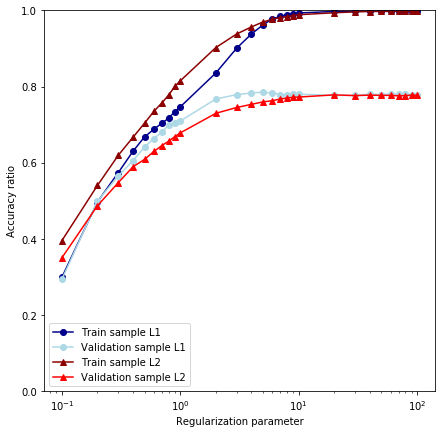

In [31]:
fig = plt.figure(figsize=(7,7))
plt.semilogx(param,train_sample_score_l1,'o-',c='darkblue' ,label='Train sample L1')
plt.semilogx(param,test_sample_score_l1 ,'o-',c='lightblue',label='Validation sample L1')
plt.semilogx(param,train_sample_score_l2,'^-',c='darkred'  ,label='Train sample L2')
plt.semilogx(param,test_sample_score_l2 ,'^-',c='red'      ,label='Validation sample L2')
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy ratio")
plt.ylim((0.0,1.0))
plt.legend()
plt.show()

We also checked if the way we generate unigrams and bigrams affects predictive power of logistic model.

We do not observe larger influence of TFIDF parameters on predictive power.

In [32]:
train_sample_score_l1 = []
test_sample_score_l1  = []

train_sample_score_l2 = []
test_sample_score_l2  = []

for df in range(3,11):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=df, norm='l2', encoding='utf-8',ngram_range=(1,1))
    features = tfidf.fit_transform(sample['txt']).toarray()
    labels = np.array(sample['Borough'])
    X_tr,  X_te, y_tr,  y_te = train_test_split(features, labels, test_size=0.30, random_state=42)
    X_val, X_te, y_val, y_te = train_test_split(X_te, y_te, test_size=0.33, random_state=42) 
    
    clf1 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l1', C=1.0)
    model = clf1.fit(X_tr, y_tr)
    train_sample_score_l1.append(model.score(X_tr, y_tr))
    test_sample_score_l1.append(model.score(X_val, y_val))

    clf2 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l2', C=1.0)
    model = clf2.fit(X_tr, y_tr)
    train_sample_score_l2.append(model.score(X_tr, y_tr))
    test_sample_score_l2.append(model.score(X_val, y_val))

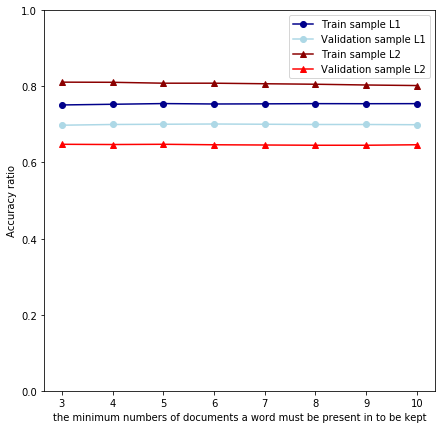

In [33]:
fig = plt.figure(figsize=(7,7))
plt.plot(range(3,11),train_sample_score_l1,'o-',c='darkblue' ,label='Train sample L1')
plt.plot(range(3,11),test_sample_score_l1 ,'o-',c='lightblue',label='Validation sample L1')
plt.plot(range(3,11),train_sample_score_l2,'^-',c='darkred'  ,label='Train sample L2')
plt.plot(range(3,11),test_sample_score_l2 ,'^-',c='red'      ,label='Validation sample L2')
plt.xlabel("the minimum numbers of documents a word must be present in to be kept")
plt.ylabel("Accuracy ratio")
plt.ylim((0.0,1.0))
plt.legend()
plt.show()

Building Model
========

We build model using logistic regression technique with regularization (L1 with regularization parameter equal 2.0). As identifying borough is multiclass problem we use *One vs Rest* algorithm. 

In [34]:
clf = LogisticRegression(random_state=0, multi_class='ovr',penalty='l1', C=2.0)
model = clf.fit(X_train, y_train)

Performance of the model is tested using test sample containing data that was not used in estimation of model or in hyperparameter tuning. 


In [35]:
res = pd.DataFrame()
res['Predict'] = model.predict(X_test) 
res['Actual']  = y_test
 
print(classification_report(res['Predict'], res['Actual']))

                precision    recall  f1-score   support

        bemowo       0.69      0.62      0.65        53
     białołęka       0.92      0.74      0.82        93
       bielany       0.59      0.89      0.71        19
       mokotów       0.91      0.65      0.76       195
        ochota       0.75      0.96      0.84        28
praga południe       0.82      0.91      0.86        55
  praga północ       0.85      0.94      0.89        31
     rembertów       0.22      1.00      0.36         2
      targówek       0.66      0.95      0.78        20
         ursus       0.68      1.00      0.81        15
       ursynów       0.67      0.90      0.77        39
         wawer       0.27      1.00      0.43         3
        wesoła       0.67      0.67      0.67         3
       wilanów       0.74      0.83      0.78        24
          wola       0.75      0.67      0.71        99
        włochy       0.23      0.60      0.33         5
   śródmieście       0.68      0.69      0.69  

Analyzing the diffusion matrix we can conculde that boroughs are usually confused with neighboring districts:
* Śródmieście -> Mokotów, Wola
* Ochota -> Mokotów, Wola, Śródmieście
* Bielany -> Żoliborz
* Wawer -> Białołęka

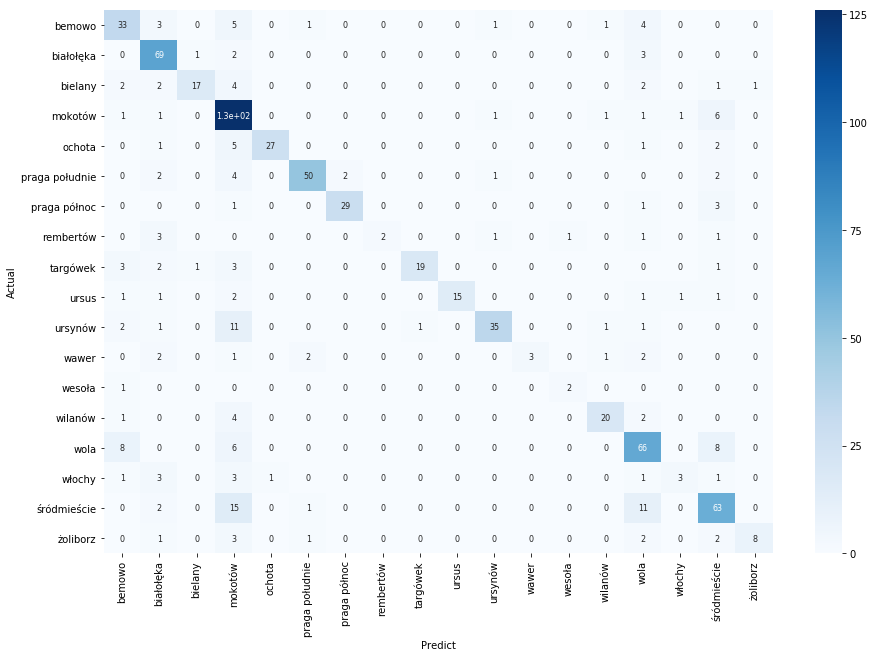

In [36]:
df_confusion = pd.crosstab(res['Actual'],res['Predict'])
plt.figure(figsize = (15,10))
sn.heatmap(df_confusion, annot=True,annot_kws={"size": 8},cmap='Blues')
plt.show()

Prices
=====

We also try to identify the price category of the flat basing on description. 

In [37]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='utf-8',ngram_range=(1,1))
features = tfidf.fit_transform(sample['txt']).toarray()
labels = np.array(sample['price_cat1'])
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.333, random_state=42) 

print('Training sample',X_train.shape[0],100*round(X_train.shape[0]/features.shape[0],3),'%')
print('Validation sample',X_validation.shape[0],100*round(X_validation.shape[0]/features.shape[0],3),'%')
print('Test sample',X_test.shape[0],100*round(X_test.shape[0]/features.shape[0],3),'%')

Training sample 5490 70.0 %
Validation sample 1569 20.0 %
Test sample 784 10.0 %


In [38]:
train_sample_score_l1 = []
test_sample_score_l1  = []

train_sample_score_l2 = []
test_sample_score_l2  = []

param = list(np.linspace(0.1,1.0,10)) + list(np.linspace(2,10,9))  + list(np.linspace(20,100,9)) 
for c in param:
    clf_l1 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l1', C=c)
    model = clf_l1.fit(X_train, y_train)
    train_sample_score_l1.append(model.score(X_train, y_train))
    test_sample_score_l1.append(model.score(X_validation, y_validation))

    clf_l2 = LogisticRegression(random_state=0, multi_class='ovr',penalty='l2', C=c)
    model = clf_l2.fit(X_train, y_train)
    train_sample_score_l2.append(model.score(X_train, y_train))
    test_sample_score_l2.append(model.score(X_validation, y_validation))

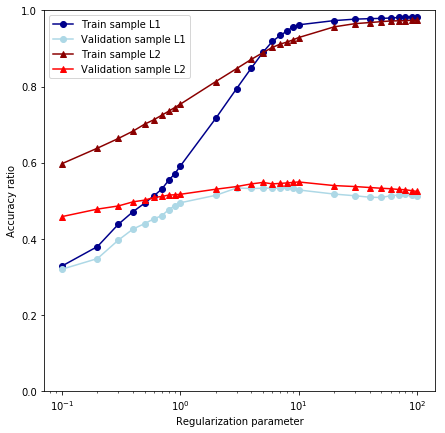

In [39]:
fig = plt.figure(figsize=(7,7))
plt.semilogx(param,train_sample_score_l1,'o-',c='darkblue' ,label='Train sample L1')
plt.semilogx(param,test_sample_score_l1 ,'o-',c='lightblue',label='Validation sample L1')
plt.semilogx(param,train_sample_score_l2,'^-',c='darkred'  ,label='Train sample L2')
plt.semilogx(param,test_sample_score_l2 ,'^-',c='red'      ,label='Validation sample L2')
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy ratio")
plt.ylim((0.0,1.0))
plt.legend()
plt.show()

The model is performing not as well as the model build to recognize the boroughs. But we see that model usually mismatch price category with its neighbouring class (like low with midlow, high with midhigh). Model has largest predictive power for extreme prices. We can conclude that probably reading description may give us a general picture: what is the price of the apartment, but precise estimation will be biased.

             precision    recall  f1-score   support

       high       0.74      0.65      0.69       172
        low       0.65      0.67      0.66       169
        mid       0.37      0.46      0.41       135
    midhigh       0.36      0.34      0.35       141
     midlow       0.47      0.44      0.45       167

avg / total       0.53      0.52      0.52       784



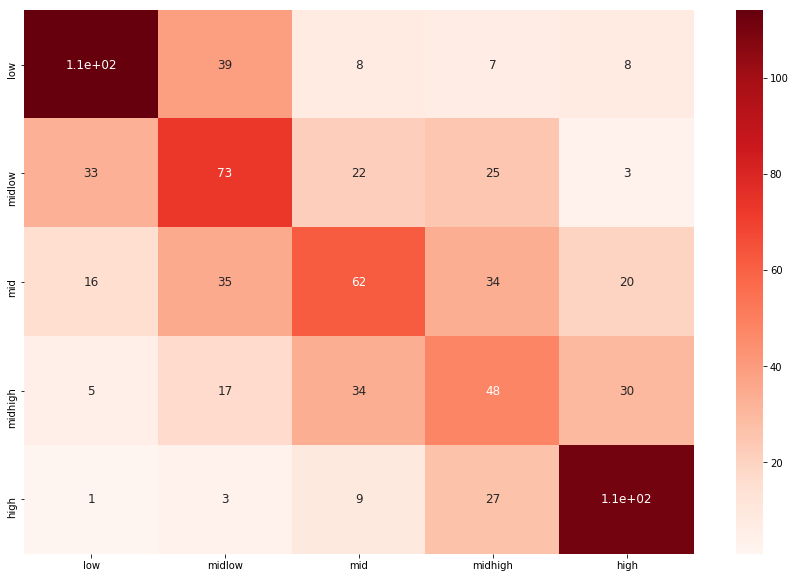

In [40]:
clf = LogisticRegression(random_state=0, multi_class='ovr',penalty='l2', C=3.0)
model = clf.fit(X_train, y_train)
res = pd.DataFrame()
res['Predict'] = model.predict(X_test) 
res['Actual']  = y_test
 
print(classification_report(res['Predict'], res['Actual']))
temp = pd.crosstab(res['Actual'],res['Predict'])
df_confusion = pd.DataFrame()
for item in ['low','midlow','mid', 'midhigh','high']:
    df_confusion = df_confusion.append(temp.loc[item].to_dict(),ignore_index=True)
df_confusion = df_confusion[['low','midlow','mid', 'midhigh','high']]
df_confusion.index = ['low','midlow','mid', 'midhigh','high']
plt.figure(figsize = (15,10))
sn.heatmap(df_confusion, annot=True,annot_kws={"size": 12},cmap='Reds')
plt.show()